<a href="https://colab.research.google.com/github/sebastiancikovsky/interference-anomaly-detector-demo/blob/main/notebooks/colab_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sebastiancikovsky/interference-anomaly-detector-demo.git
%cd interference-anomaly-detector-demo

!pip install -r requirements.txt


Cloning into 'interference-anomaly-detector-demo'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 18 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 81.79 KiB | 4.09 MiB/s, done.
Resolving deltas: 100% (1/1), done.
/content/interference-anomaly-detector-demo


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc

import sys
sys.path.append(".")

from pca_pipeline_demo import PCAPipeline
from anomaly_detection_demo import SimpleAnomalyDetector


In [3]:
df = pd.read_csv("sample_data.csv")
print(df.head())
print("Shape:", df.shape)
print("Class counts:\n", df["label"].value_counts())


   channel_0  channel_1  channel_2  channel_3  channel_4  channel_5  \
0   0.722361   1.130597  -1.463155   0.160906  -1.121609   0.167007   
1  -0.428573  -0.024568   0.477485  -0.051586   0.321091   0.030575   
2   0.410396  -0.678527  -0.751947  -0.115777  -3.396075  -0.964092   
3  -0.070492   0.776581  -1.577056  -0.227046   0.723720   0.456182   
4   0.664542  -1.247413   0.625338   0.177341  -1.063807   0.805729   

   channel_6  channel_7  label  
0  -0.862272   0.149360    0.0  
1  -0.082476  -0.179180    0.0  
2  -0.619303   1.204099    0.0  
3  -0.072718  -0.118857    0.0  
4  -0.718936  -0.476050    0.0  
Shape: (1050, 9)
Class counts:
 label
0.0    1000
1.0      50
Name: count, dtype: int64


In [4]:
X = df.drop("label", axis=1).values
y = df["label"].values

pca = PCAPipeline()  # n_components=0.95 inside
pca.fit(X)

Z = pca.transform(X)
errors = pca.reconstruction_error(X)


In [5]:
# Threshold-based anomaly detector
detector = SimpleAnomalyDetector(threshold_std=3.0)
detector.fit(errors)
pred_flags = detector.predict(errors)

print("Detected anomalies (threshold-based):", pred_flags.sum())

# Logistic regression classifier in latent space
clf = LogisticRegression(max_iter=1000)
clf.fit(Z, y)
y_pred = clf.predict(Z)

print("\nClassification report (latent space logistic regression):")
print(classification_report(y, y_pred))


Detected anomalies (threshold-based): 26

Classification report (latent space logistic regression):
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1000
         1.0       1.00      1.00      1.00        50

    accuracy                           1.00      1050
   macro avg       1.00      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050



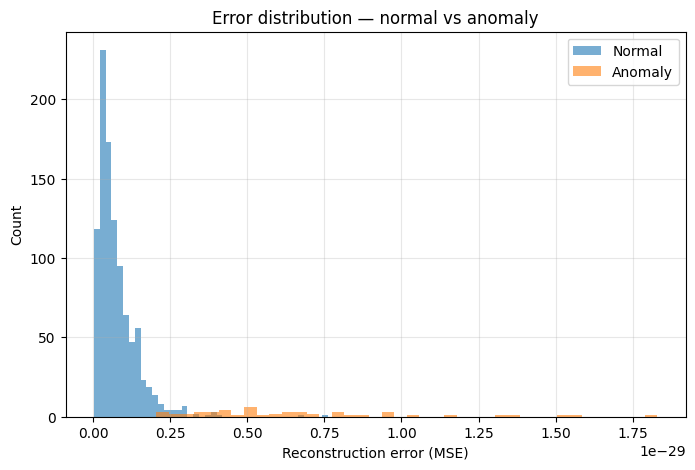

In [6]:
plt.figure(figsize=(8,5))
plt.hist(errors[y == 0], bins=40, alpha=0.6, label="Normal")
plt.hist(errors[y == 1], bins=40, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("Count")
plt.title("Error distribution — normal vs anomaly")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


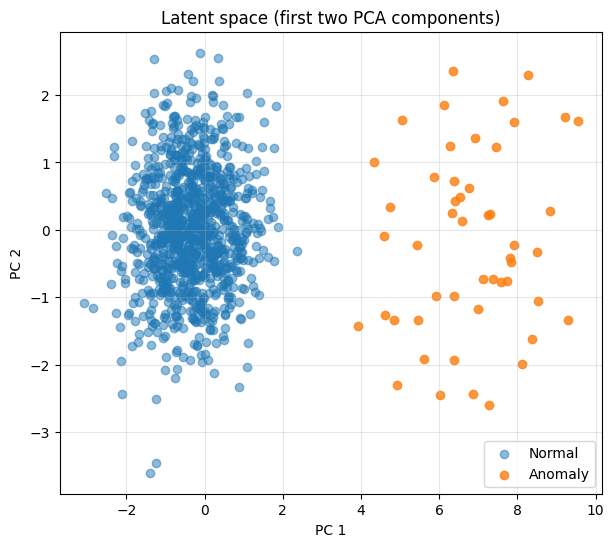

In [7]:
if Z.shape[1] >= 2:
    plt.figure(figsize=(7,6))
    plt.scatter(Z[y == 0, 0], Z[y == 0, 1], alpha=0.5, label="Normal")
    plt.scatter(Z[y == 1, 0], Z[y == 1, 1], alpha=0.8, label="Anomaly")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("Latent space (first two PCA components)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Latent dimension < 2 — skipping plot.")


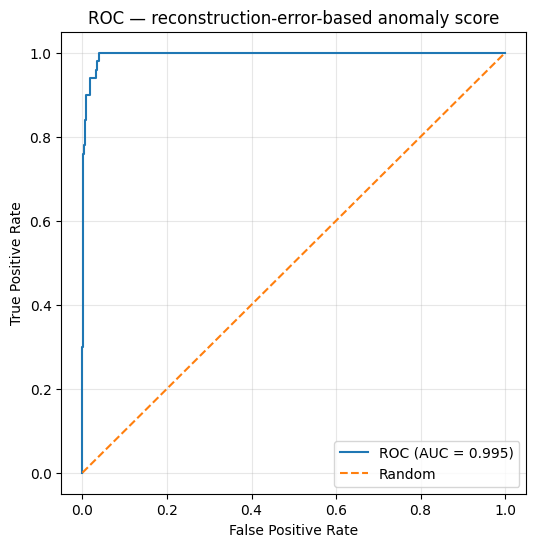

In [8]:
fpr, tpr, _ = roc_curve(y, errors)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — reconstruction-error-based anomaly score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
